In [13]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

from transformers import get_scheduler
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments

from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

In [2]:
label_to_id = {"entailment": 0, "neutral": 1, "contradiction": 2}
id_to_label = {v: k for k, v in label_to_id.items()}

def renameColumns(df):
    return df.rename(columns={'Sentence1': 'premise', 'Sentence2': 'hypothesis', 'Explanation_1': 'explanation'})

def filterNan(df):
    return df.dropna()

def convert_to_tensors(df):
    return torch.tensor(df.values)

def encode_labels(df):
    return df.apply(lambda x: int(label_to_id[x]))

template = "Given that {}, it is hypothesized that {}. {}."

def tokenize(df, tokenizer):
    tokenized_batch = []
    for _, row in df.iterrows():
        premise = row['premise'].lower()
        if premise[-1] in ['.', '!', '?']:
            premise = premise[:-1]
        hypothesis = row['hypothesis'].lower()
        if hypothesis[-1] in ['.', '!', '?']:
            hypothesis = hypothesis[:-1]
        explanation = row['explanation'].lower()
        if explanation[-1] in ['.', '!', '?']:
            explanation = explanation[:-1]


        encoded_dict = tokenizer.encode_plus(
            text = template.format(premise, hypothesis, explanation),
            padding=True,
            return_tensors='pt',
        )
        tokenized_batch.append(encoded_dict)
    return tokenized_batch

def calc_f1_score(predicted_classes, actual_labels):
    return f1_score(predicted_classes, actual_labels, average='weighted'), f1_score(predicted_classes, actual_labels, average='micro'), f1_score(predicted_classes, actual_labels, average='macro')

In [3]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# change the model's classifier to a smaller one
dense = nn.Linear(768, 256)
out = nn.Linear(256, 3)
model.classifier.dense = dense
model.classifier.out_proj = out

# freeze all the parameters in the base model
for name, param in model.named_parameters():
    param.requires_grad = False

# only train the classification head
for param in model.classifier.parameters():
    param.requires_grad = True

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
premise_template = 'Given that {}, it is hypothesized that {}.'
explanation_template = 'This is {} because {}.'

class eSNLIDataset(Dataset):
    def __init__(self, df, tokenizer, train=True):
        self.df = df
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        example = self.df.iloc[idx,:]
        premise = example["premise"]
        hypothesis = example["hypothesis"]
        explanation = example["explanation"]

        if premise[-1] in ['.', '!', '?']:
            premise = premise[:-1]
        if hypothesis[-1] in ['.', '!', '?']:
            hypothesis = hypothesis[:-1]
        if explanation[-1] in ['.', '!', '?']:
            explanation = explanation[:-1]

        premise = premise_template.format(premise, hypothesis)
        explanation = explanation_template.format(tokenizer.mask_token, explanation)

        if self.train:
            label = example["gold_label"]
            return premise, explanation, label
        
        return premise, explanation

In [5]:
df_train1 = pd.read_csv('../data/esnli_train_1.csv')
df_train2 = pd.read_csv('../data/esnli_train_2.csv')
df_train = pd.concat((df_train1, df_train2), axis=0)

df_dev = pd.read_csv('../data/esnli_dev.csv')
df_test = pd.read_csv('../data/esnli_test.csv')

In [6]:
df_train_renamed = renameColumns(df_train)
df_train_cleaned = filterNan(df_train_renamed)
df_train_cleaned.loc[:, "gold_label"] = encode_labels(df_train_cleaned["gold_label"])
df_train_final = df_train_cleaned.loc[:, ["gold_label", "premise", "hypothesis", "explanation"]]

df_train_final = df_train_final.sample(n=5000, random_state=0).reset_index(drop=True)

df_dev_renamed = renameColumns(df_dev)
df_dev_cleaned = filterNan(df_dev_renamed)
df_dev_cleaned.loc[:, "gold_label"] = encode_labels(df_dev_cleaned["gold_label"])
df_dev_final = df_dev_cleaned.loc[:, ["gold_label", "premise", "hypothesis", "explanation"]]

df_test_renamed = renameColumns(df_test)

In [7]:
num_epochs = 1
train_batch_size = 16

In [8]:
train_dataset = eSNLIDataset(df_train_final, tokenizer)
dev_dataset = eSNLIDataset(df_dev_final, tokenizer, train=False)
test_dataset = eSNLIDataset(df_test, tokenizer, train=False)
 
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size)
dev_dataloader = DataLoader(dev_dataset, batch_size=train_batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=train_batch_size)

In [9]:
# for mac
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# for nvidia GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
optimizer = AdamW(model.parameters(), lr=5e-6, weight_decay=0.01)
num_training_steps = num_epochs * len(train_dataloader) # <- number of batches
# lr_scheduler = get_scheduler(
#     name="linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=num_training_steps
# )
criterion = CrossEntropyLoss()

In [36]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

y_true = []
losses = []

model.to(device)
for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    for batch in train_dataloader:
        premise, hypothesis, labels = batch

        encoded_input = tokenizer(premise, hypothesis, return_tensors="pt",padding=True, truncation=True).to(device)
        
        outputs = model(**encoded_input)
        logits = outputs.logits.to(device)

        loss = criterion(logits, labels.to(device))
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        # lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/313 [00:00<?, ?it/s]

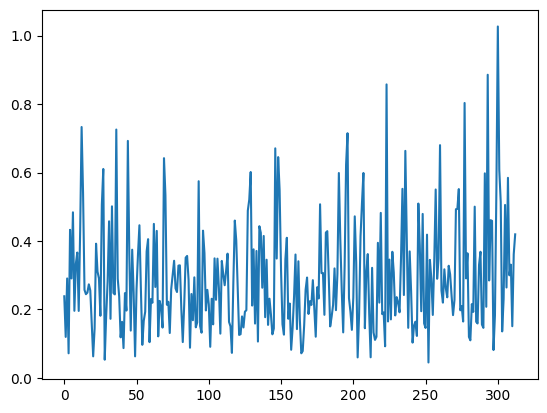

In [37]:
plt.plot(losses)
plt.show()

In [38]:
# predict after training
model.to(device)
model.eval()
predictions = []

actual_labels = df_dev_final['gold_label'].astype("int")

with torch.no_grad():
    for batch in dev_dataset:
        premise, hypothesis = batch
        
        encoded_input = tokenizer(premise, hypothesis, return_tensors="pt",padding=True, truncation=True).to(device)

        outputs = model(**encoded_input)
        logits = outputs.logits.cpu()

        predicted_classes = torch.argmax(logits, dim=1)
        predicted_classes = [pred.item() for pred in predicted_classes]
        predictions.extend(predicted_classes)

In [39]:
print(calc_f1_score(predictions, actual_labels))

(0.882722990724955, 0.8828490144279618, 0.8826958797527319)
